In [ ]:






import bayesflow as bf
import numpy as np


import rpy2.robjects as robjects
import numpy as np

In [83]:
import rpy2.robjects as robjects
import numpy as np

# 从 R 中加载数据
robjects.r('load("SpainPROV_CerebrovascularDiseases.Rdata")')

Rs = robjects.r('as.matrix(Rs)')

# 将 Rs 转换为 NumPy 数组
Rs_numpy = np.array(Rs)

# 检查矩阵的维度
print("Rs_numpy shape:", Rs_numpy.shape)


Rs_numpy shape: (47, 47)


In [84]:
# 计算特征分解
eigenvalues, eigenvectors = np.linalg.eig(Rs_numpy)

# 打印特征值和特征向量
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

# 计算协方差矩阵 Q
Q = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T  # Q = V * D * V.T
print("Covariance matrix Q:", Q)


Eigenvalues: [4.02898372e+00 3.91760840e+00 1.16270678e-16 8.70103967e-02
 1.36471249e-01 3.68894189e+00 2.84373915e-01 3.35903480e-01
 4.24394939e-01 3.57526766e+00 3.48700471e+00 5.49480100e-01
 6.86479773e-01 3.28806127e+00 3.24627671e+00 3.22501234e+00
 8.25429149e-01 9.23508897e-01 9.38544804e-01 1.00121440e+00
 1.08337936e+00 3.09257535e+00 1.18549682e+00 1.31239606e+00
 1.37151192e+00 1.41839871e+00 1.47548171e+00 2.94744613e+00
 2.90831092e+00 2.81326532e+00 2.78203196e+00 2.70367067e+00
 2.65184367e+00 2.55747008e+00 2.53141064e+00 2.45001418e+00
 2.38822842e+00 2.32899568e+00 2.26667887e+00 2.10897083e+00
 2.09243660e+00 1.96124040e+00 1.90970136e+00 1.87819751e+00
 1.75053418e+00 1.68927737e+00 1.71788199e+00]
Eigenvectors: [[ 0.09193583  0.12350732 -0.14586499 ...  0.16560432  0.01980325
   0.00368928]
 [ 0.05232506 -0.14409124 -0.14586499 ...  0.07575858 -0.08023009
   0.07457773]
 [-0.00563195  0.02052873 -0.14586499 ... -0.04477425  0.08674872
  -0.07251008]
 ...
 [ 0.07

In [85]:
eigenvalues, _ = np.linalg.eig(Q)
print("Eigenvalues of Q:", eigenvalues)


Eigenvalues of Q: [ 4.02898372e+00  3.91760840e+00 -1.27713007e-17  8.70103967e-02
  1.36471249e-01  3.68894189e+00  2.84373915e-01  3.35903480e-01
  4.24394939e-01  3.57526766e+00  3.48700471e+00  5.49480100e-01
  6.86479773e-01  3.28806127e+00  3.24627671e+00  3.22501234e+00
  8.25429149e-01  9.23508897e-01  9.38544804e-01  1.00121440e+00
  1.08337936e+00  3.09257535e+00  1.18549682e+00  1.31239606e+00
  1.37151192e+00  1.41839871e+00  1.47548171e+00  2.94744613e+00
  2.90831092e+00  2.81326532e+00  2.78203196e+00  2.70367067e+00
  2.65184367e+00  2.55747008e+00  2.53141064e+00  2.45001418e+00
  2.38822842e+00  2.32899568e+00  2.26667887e+00  2.10897083e+00
  2.09243660e+00  1.96124040e+00  1.90970136e+00  1.87819751e+00
  1.75053418e+00  1.68927737e+00  1.71788199e+00]


In [96]:
import numpy as np
import bayesflow as bf

###############################################################################
# 1) 纯 numpy 模拟函数：theta_step + forward_step
###############################################################################
# Q = np.eye(47, dtype=np.float32)
mu = np.zeros(47, dtype=np.float32)
n_obs = 100

def theta_step(batch_shape=1, **kwargs):
    """
    先验采样。返回 {"theta": [batch_size, 48]}，其中前 47 维是 log_risk, 
    最后一维是 tau。

    注意：
    - batch_shape 可能是整数或元组 (N,)；需先转成 batch_size 用于采样。
    - 我们用 np.random.uniform 和 np.random.multivariate_normal 采样。
    """
    # 1) 解析 batch_size
    if isinstance(batch_shape, int):
        batch_size = batch_shape
    else:
        # 如果传入的是 (N,) 形式，就取 N
        batch_size = batch_shape[0]

    # 2) 采样 tau ~ Uniform(1,2)  => shape [batch_size]
    tau = np.random.uniform(low=1.0, high=2.0, size=batch_size).astype(np.float32)

    # 3) 对于每个 tau[i]，协方差 = tau[i]*Q，然后多元正态采样 47维 log_risk
    all_samples = []
    for i in range(batch_size):
        # loc=mu, cov= tau[i]*Q
        sample_47 = np.random.multivariate_normal(mean=mu, cov=tau[i]*Q)
        all_samples.append(sample_47)
    log_risk_samples = np.stack(all_samples, axis=0).astype(np.float32)  # [batch_size,47]

    # 4) 拼成 [batch_size,48]
    tau_2d = tau.reshape(batch_size, 1)
    theta_48 = np.concatenate([log_risk_samples, tau_2d], axis=-1)  # [batch_size,48]

    return {"theta": theta_48}

# def theta_step(batch_shape=1, **kwargs):
#     """
#     先验采样，返回 {"theta": [n, 48]}，其中前 47 维是 log_risk，
#     最后一维是 tau。
#     
#     参数:
#       - batch_shape: 若为整数则表示批量大小；当 batch_size==1 时，
#           本函数会返回一个 tau 网格（长度 k）的样本，形状为 (k, 48)；
#           若 batch_size > 1，则每个样本随机从 tau 网格中抽取一个值。
#       - tau_range: 一个二元组，表示 tau 的取值区间 (min, max)。
#       - k: 生成 tau 网格的点数。
#       - 其他关键字参数。
#       
#     注意：本函数使用全局变量 mu 和 Q（协方差矩阵）来采样 47 维 log_risk，
#            并将 tau 作为最后一维附加到 log_risk 后面。
#     """
#     tau_range=(4, 40)
#     k=100
#     
#     # 1) 解析 batch_size
#     if isinstance(batch_shape, int):
#         batch_size = batch_shape
#     else:
#         batch_size = batch_shape[0]
#     
#     # 2) 生成 tau
#     tau_grid = np.linspace(tau_range[0], tau_range[1], num=k).astype(np.float32)
#     
#     if batch_size == 1:
#         # 当 batch_size==1 时，返回 tau_grid 上的所有点
#         tau = tau_grid  # shape: (k,)
#     else:
#         # 当 batch_size > 1 时，从 tau_grid 中随机选取一个 tau 给每个样本
#         indices = np.random.choice(k, size=batch_size, replace=True)
#         tau = tau_grid[indices]  # shape: (batch_size,)
#     
#     # 3) 对于每个 tau 生成 47 维的 log_risk
#     all_samples = []
#     # 注意：如果 batch_size==1，则 tau 的长度为 k；否则长度为 batch_size
#     for t in tau:
#         # 这里假设全局变量 mu (shape: (47,)) 和 Q (shape: (47,47)) 已定义
#         sample_47 = np.random.multivariate_normal(mean=mu, cov=t * Q)
#         all_samples.append(sample_47)
#     log_risk_samples = np.stack(all_samples, axis=0).astype(np.float32)  # shape: (n, 47)，其中 n = (k 或 batch_size)
#     
#     # 4) 拼接 tau（扩展为二维）与 log_risk 得到 theta
#     tau_2d = tau.reshape(-1, 1)  # shape: (n, 1)
#     theta_48 = np.concatenate([log_risk_samples, tau_2d], axis=-1)  # shape: (n, 48)
#     
#     return {"theta": theta_48}


###############################################################################
# 3) 定义前向模拟 (forward_step) - 用纯 numpy
###############################################################################
def forward_step(theta, **kwargs):
    """
    接收上一步返回的 "theta": [batch_size, 48]，根据 log_risk 采样泊松数据。
    返回 {"x": [batch_size, n_obs, 47]}。
    """
    batch_size = theta.shape[0]
    log_risk   = theta[:, :47]  # [batch_size,47]
    # tau = theta[:, -1]        # 如果需要用 tau，也可以取出
    
    # 1) lam = exp(log_risk)
    lam = np.exp(log_risk)
    
    # 2) 每个样本采样 n_obs=100 条泊松 => [n_obs, 47]
    #    最后 stack 成 [batch_size, n_obs, 47]
    all_obs = []
    for i in range(batch_size):
        # lam[i]: shape [47]
        # 采样 n_obs 个 47维泊松 => shape (n_obs, 47)
        obs_i = np.random.poisson(lam=lam[i], size=(n_obs, 47)).astype(np.float32)
        all_obs.append(obs_i)
    x = np.stack(all_obs, axis=0)  # [batch_size, n_obs, 47]
    
    return {"x": x}





In [97]:
###############################################################################
# 2) 创建模拟器，禁止 expand_outputs
###############################################################################

# simulator = bf.make_simulator(
#     [theta_step, forward_step],
#     expand_outputs=False
# )

def squeeze_step(theta=None, x=None, **kwargs):
    out = {}
    if theta is not None:
        out["theta"] = np.squeeze(theta)  # 自动删除所有 size=1 维度
    if x is not None:
        out["x"] = np.squeeze(x)  # 自动删除所有 size=1 维度
    return out


simulator = bf.make_simulator(
    [theta_step, forward_step, squeeze_step],
    expand_outputs=False
)



# 快速测试
test_data = simulator.sample((2,))
# test_data["theta"].shape => (2, 48)
# test_data["x"].shape => (2, 100, 47)
print("Test data shapes =>")
for k, v in test_data.items():
    print(f"{k}: {v.shape}")



###############################################################################
# 3) 构造 Adapter - 将 "theta"->inference_variables, "x"->inference_conditions
###############################################################################
def flatten_inference_conditions(data, **kwargs):
    # data 应该包含 'inference_variables' 和 'inference_conditions'
    if "inference_conditions" in data:
        conditions = data["inference_conditions"]
        # 将 inference_conditions 从 (batch_size, 100, 47) 扁平化为 (batch_size, 4700)
        data["inference_conditions"] = conditions.reshape(conditions.shape[0], -1)
    return data



adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")  # 确保数据为 float32
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
    .append(flatten_inference_conditions)  # 添加扁平化步骤
)




###############################################################################
# 4) 定义网络：FlowMatching + 自定义 base_distribution
###############################################################################
# 替换掉默认 DiagonalNormal 为 TFP MultivariateNormalDiag(0,I)
# => 这样 .sample(...) 就支持 seed 参数
dim_theta = 48

flow_matching = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs={
        "widths": (256,)*4,   # 随便设4层256宽
        "dropout": 0.0,
        "residual": True
    }
)

base_dist = bf.distributions.DiagonalNormal(
    mean=np.zeros(dim_theta, dtype=np.float32),
    std=np.ones(dim_theta, dtype=np.float32)
)
# 手动设置分布的维度：
base_dist.dim = dim_theta

flow_matching.base_distribution = base_dist


###############################################################################
# 5) Workflow + Offline 训练
###############################################################################
flow_matching_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=flow_matching,
)


Test data shapes =>
theta: (2, 48)
x: (2, 100, 47)


In [98]:
# 5.1) 生成离线数据
num_training_batches   = 512
num_validation_batches = 128
batch_size            = 64
epochs                = 10

print("Generating training data...")
training_data   = simulator.sample((num_training_batches * batch_size,))
print("Generating validation data...")
validation_data = simulator.sample((num_validation_batches * batch_size,))

print("Shapes =>")
print("  theta:", training_data["theta"].shape)  # e.g. (32768,48)
print("  x:    ", training_data["x"].shape)      # e.g. (32768,100,47)



Generating training data...
Generating validation data...
Shapes =>
  theta: (32768, 48)
  x:     (32768, 100, 47)


In [99]:
print("\nStart offline training...\n")
history = flow_matching_workflow.fit_offline(
    training_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_data
)
print("Training finished!")

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.



Start offline training...

Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4869.6558 - loss/inference_loss: 4869.6558 - val_loss: 4.0380 - val_loss/inference_loss: 4.0380
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 14.6576 - loss/inference_loss: 14.6576 - val_loss: 24.1330 - val_loss/inference_loss: 24.1330
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.3194 - loss/inference_loss: 4.3194 - val_loss: 3.7791 - val_loss/inference_loss: 3.7791
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9117 - loss/inference_loss: 3.9117 - val_loss: 3.9470 - val_loss/inference_loss: 3.9470
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.2515 - loss/inference_loss: 4.2515 - val_loss: 4.0169 - val_loss/inference_loss: 4.0169
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.8774 - loss/inference_loss: 3.8774 - val_loss: 4.0570 - val_loss/inference_loss: 4.0570
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - l

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 生成测试数据（调用 simulator 得到原始数据，经 adapter 转换后键名为 inference_variables 和 inference_conditions）
test_size = 1
test_batch = simulator.sample((test_size,))

# 提取 theta_true 和 x_test
theta_true = test_batch["theta"]  # [test_size, 48]
x_test = test_batch["x"]  # [test_size, 4700]

# 2. 设定后验采样数量
num_samples = 300

# 3. 进行后验采样
# 这里遍历多个测试样本，分别对每个样本进行采样
posterior_samples_flow = flow_matching_workflow.approximator.sample(
    conditions={"inference_conditions": x_test},  # 改为 inference_conditions
    num_samples=num_samples
)["theta"]



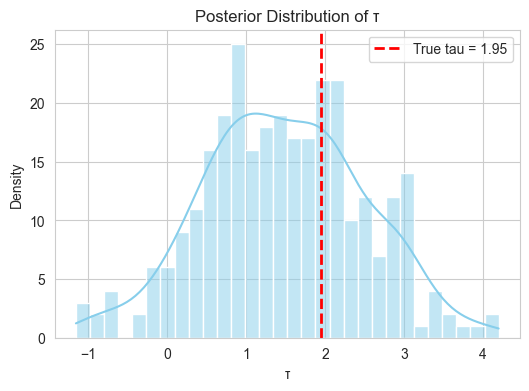

In [101]:

import matplotlib.pyplot as plt
import seaborn as sns

# 提取 tau 的采样（对于第一个测试样本）
tau_samples = posterior_samples_flow[0, :, -1]  # shape: (300,)
tau_true = theta_true[0, -1]               # 标量

plt.figure(figsize=(6, 4))
sns.histplot(tau_samples, bins=30, kde=True, color="skyblue")
plt.axvline(tau_true, color='red', linestyle='--', linewidth=2,
            label=f"True tau = {tau_true:.2f}")
plt.title("Posterior Distribution of τ")
plt.xlabel("τ")
plt.ylabel("Density")
plt.legend()
plt.show()



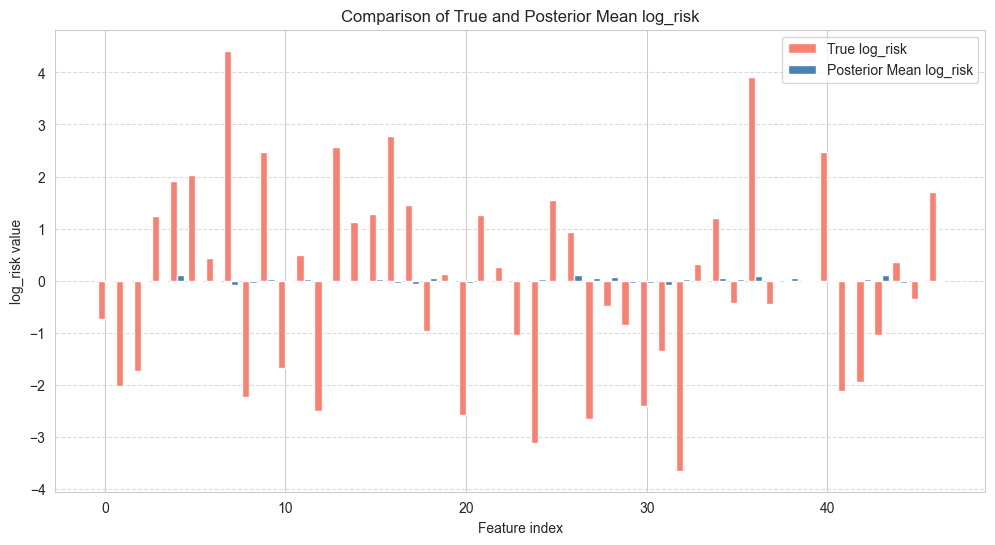

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 提取 log_risk 部分
log_risk_samples = posterior_samples_flow[0, :, :47]  # shape: (300, 47)
log_risk_mean = np.mean(log_risk_samples, axis=0)  # shape: (47,)
log_risk_true = theta_true[0, :47]                 # shape: (47,)

x = np.arange(47)

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, log_risk_true, width=0.4, label="True log_risk", color="salmon")
plt.bar(x + 0.2, log_risk_mean, width=0.4, label="Posterior Mean log_risk", color="steelblue")
plt.xlabel("Feature index")
plt.ylabel("log_risk value")
plt.title("Comparison of True and Posterior Mean log_risk")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


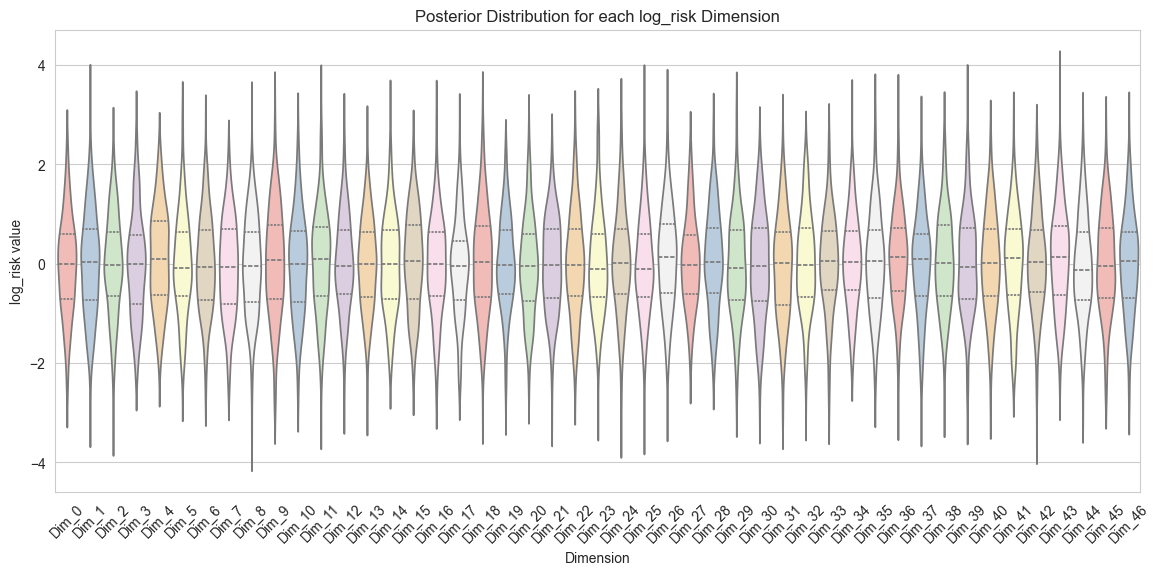

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 将后验采样转为 DataFrame，每列对应一个 log_risk 维度
data = pd.DataFrame(log_risk_samples, columns=[f"Dim_{i}" for i in range(47)])

plt.figure(figsize=(14, 6))
sns.violinplot(data=data, inner="quartile", palette="Pastel1")
plt.xticks(rotation=45)
plt.xlabel("Dimension")
plt.ylabel("log_risk value")
plt.title("Posterior Distribution for each log_risk Dimension")
plt.show()


In [104]:
affine_flow = bf.networks.CouplingFlow(subnet="mlp")

spline_flow = bf.networks.CouplingFlow(subnet="mlp", transform="spline")

In [105]:
affine_flow_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=affine_flow,
)


spline_flow_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=spline_flow,
)

In [109]:
history = affine_flow_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - loss: 272.1103 - loss/inference_loss: 272.1103 - val_loss: 67.1193 - val_loss/inference_loss: 67.1193
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 4812.2744 - loss/inference_loss: 4812.2744 - val_loss: 49.2659 - val_loss/inference_loss: 49.2659
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - loss: 174.2605 - loss/inference_loss: 174.2605 - val_loss: 46.9794 - val_loss/inference_loss: 46.9794
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 196.3398 - loss/inference_loss: 196.3398 - val_loss: 43.0741 - val_loss/inference_loss: 43.0741
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 233973.9375 - loss/inference_loss: 233973.9375 - val_loss: 29.4330 - val_loss/inference_loss: 29.4330
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - loss: 9470.9561 - loss/inference_loss: 9470.9561 - val_loss: 22.1615 - val_loss/inference_loss: 22.1615
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 31

In [106]:
history = spline_flow_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 68s 98ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - loss: nan - loss/inference_loss: nan - val_loss: nan - val_loss/inference_loss: nan
Epoch 8/10
512/512 ━

In [107]:
# Compute the empirical variance of the draws from the prior θ ~ p(θ)
consistency_model = bf.networks.ConsistencyModel(
    subnet="mlp",
    subnet_kwargs={"widths": (256,)*6, "dropout": 0.0, "residual": True},
    total_steps=num_training_batches*epochs,
    max_time=10, # this probably needs to be tuned for a novel application
    sigma2=1.0,  # the data adapter standardizes our parameters, so set to 1.0
)

# Workflow for consistency model
consistency_model_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=consistency_model,
)

In [108]:
history = consistency_model_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.6780 - loss/inference_loss: 0.6780 - val_loss: 0.5890 - val_loss/inference_loss: 0.5890
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6387 - loss/inference_loss: 0.6387 - val_loss: 0.6521 - val_loss/inference_loss: 0.6521
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6373 - loss/inference_loss: 0.6373 - val_loss: 0.6051 - val_loss/inference_loss: 0.6051
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6168 - loss/inference_loss: 0.6168 - val_loss: 0.6626 - val_loss/inference_loss: 0.6626
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6161 - loss/inference_loss: 0.6161 - val_loss: 0.5965 - val_loss/inference_loss: 0.5965
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6170 - loss/inference_loss: 0.6170 - val_loss: 0.5927 - val_loss/inference_loss: 0.5927
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5787 - loss/inference_loss: 0.5

In [110]:
posterior_samples_consistency= consistency_model_workflow.approximator.sample(
    conditions={"inference_conditions": x_test},  # 改为 inference_conditions
    num_samples=num_samples
)["theta"]

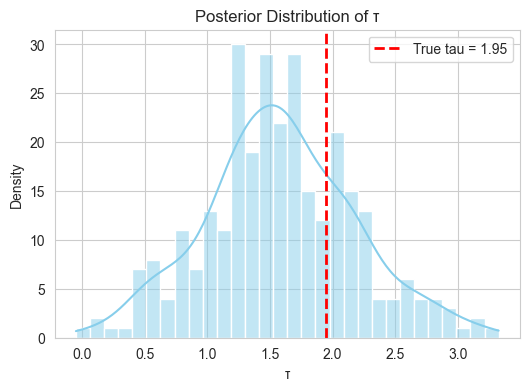

In [111]:

import matplotlib.pyplot as plt
import seaborn as sns

# 提取 tau 的采样（对于第一个测试样本）
tau_samples = posterior_samples_consistency[0, :, -1]  # shape: (300,)
tau_true = theta_true[0, -1]               # 标量

plt.figure(figsize=(6, 4))
sns.histplot(tau_samples, bins=30, kde=True, color="skyblue")
plt.axvline(tau_true, color='red', linestyle='--', linewidth=2,
            label=f"True tau = {tau_true:.2f}")
plt.title("Posterior Distribution of τ")
plt.xlabel("τ")
plt.ylabel("Density")
plt.legend()
plt.show()



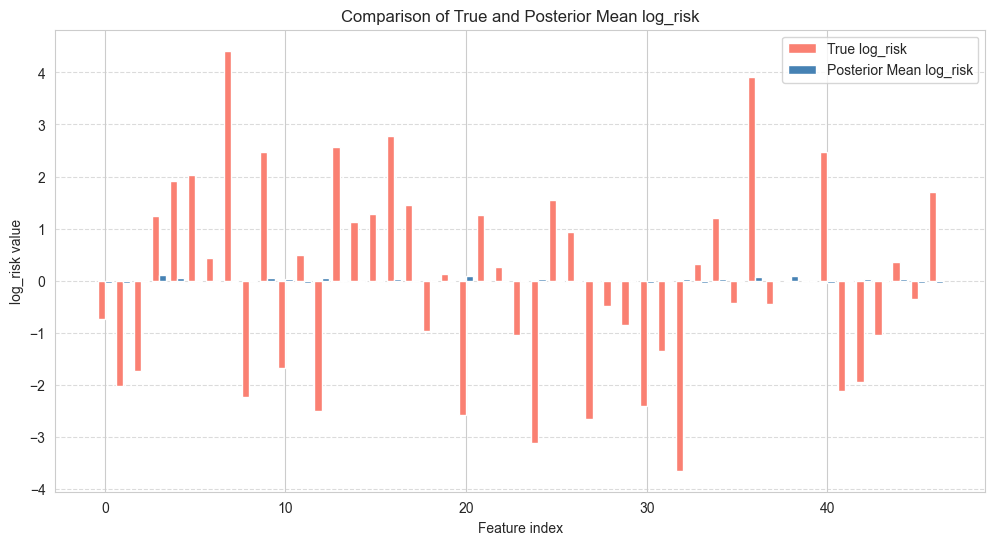

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# 提取 log_risk 部分
log_risk_samples = posterior_samples_consistency[0, :, :47]  # shape: (300, 47)
log_risk_mean = np.mean(log_risk_samples, axis=0)  # shape: (47,)
log_risk_true = theta_true[0, :47]                 # shape: (47,)

x = np.arange(47)

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, log_risk_true, width=0.4, label="True log_risk", color="salmon")
plt.bar(x + 0.2, log_risk_mean, width=0.4, label="Posterior Mean log_risk", color="steelblue")
plt.xlabel("Feature index")
plt.ylabel("log_risk value")
plt.title("Comparison of True and Posterior Mean log_risk")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [113]:
posterior_samples_affine= affine_flow_workflow.approximator.sample(
    conditions={"inference_conditions": x_test},  # 改为 inference_conditions
    num_samples=num_samples
)["theta"]

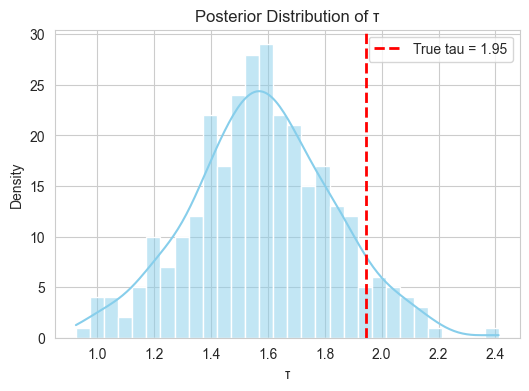

In [114]:

import matplotlib.pyplot as plt
import seaborn as sns

# 提取 tau 的采样（对于第一个测试样本）
tau_samples = posterior_samples_affine[0, :, -1]  # shape: (300,)
tau_true = theta_true[0, -1]               # 标量

plt.figure(figsize=(6, 4))
sns.histplot(tau_samples, bins=30, kde=True, color="skyblue")
plt.axvline(tau_true, color='red', linestyle='--', linewidth=2,
            label=f"True tau = {tau_true:.2f}")
plt.title("Posterior Distribution of τ")
plt.xlabel("τ")
plt.ylabel("Density")
plt.legend()
plt.show()



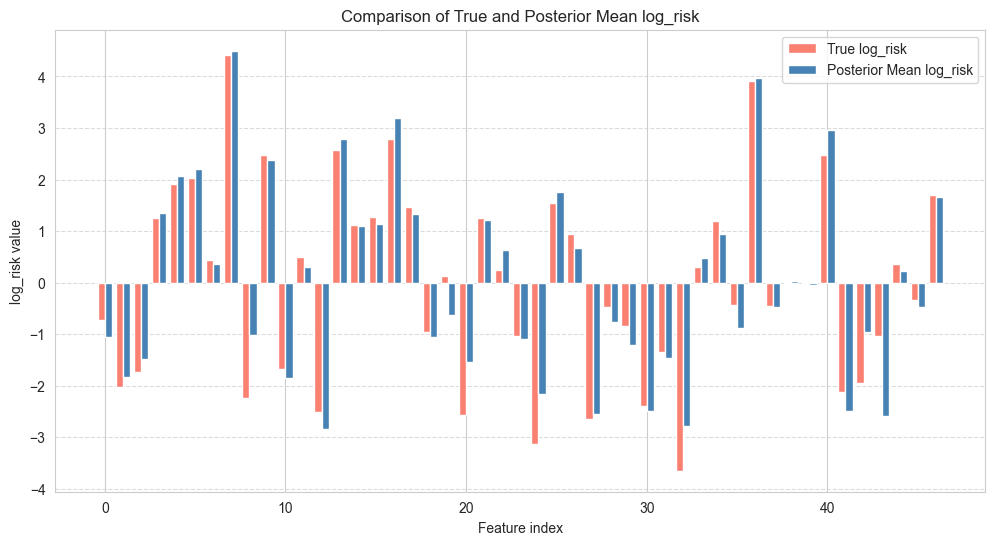

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# 提取 log_risk 部分
log_risk_samples = posterior_samples_affine[0, :, :47]  # shape: (300, 47)
log_risk_mean = np.mean(log_risk_samples, axis=0)  # shape: (47,)
log_risk_true = theta_true[0, :47]                 # shape: (47,)

x = np.arange(47)

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, log_risk_true, width=0.4, label="True log_risk", color="salmon")
plt.bar(x + 0.2, log_risk_mean, width=0.4, label="Posterior Mean log_risk", color="steelblue")
plt.xlabel("Feature index")
plt.ylabel("log_risk value")
plt.title("Comparison of True and Posterior Mean log_risk")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


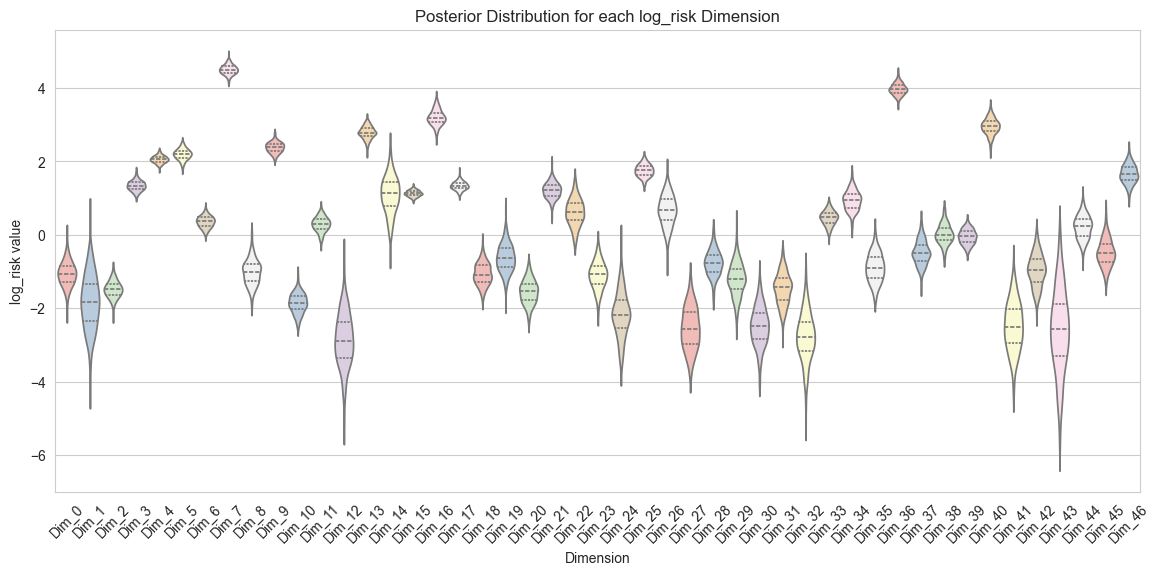

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 将后验采样转为 DataFrame，每列对应一个 log_risk 维度
data = pd.DataFrame(log_risk_samples, columns=[f"Dim_{i}" for i in range(47)])

plt.figure(figsize=(14, 6))
sns.violinplot(data=data, inner="quartile", palette="Pastel1")
plt.xticks(rotation=45)
plt.xlabel("Dimension")
plt.ylabel("log_risk value")
plt.title("Posterior Distribution for each log_risk Dimension")
plt.show()


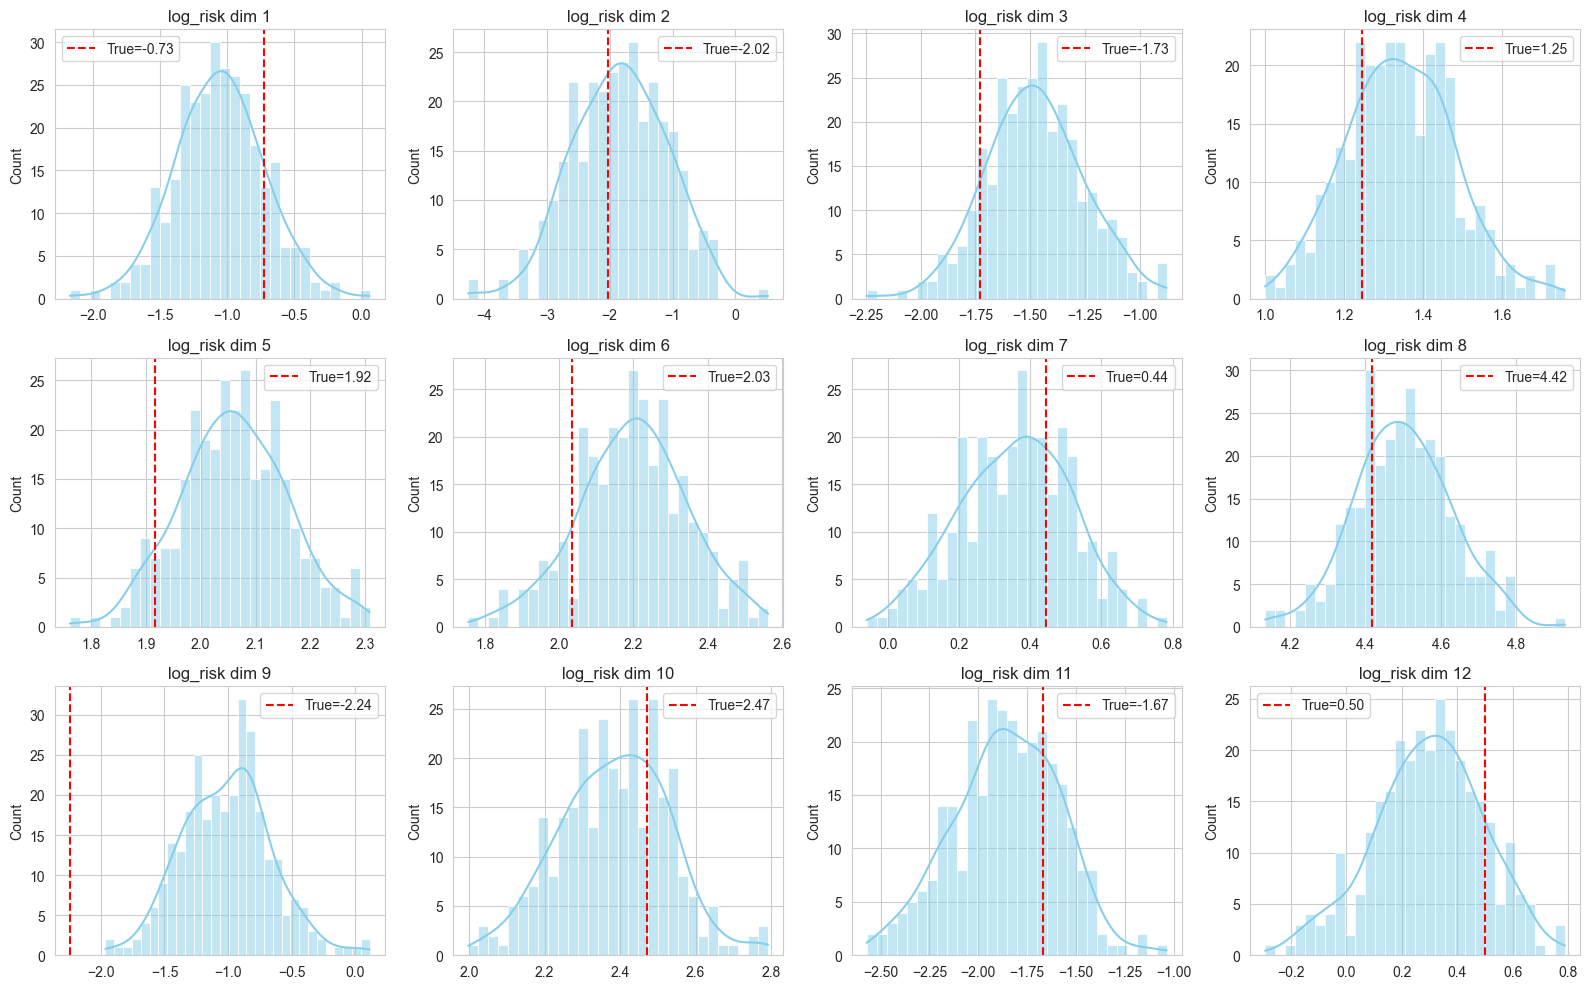

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 取出单个样本的后验采样 => shape (300, 48)
posterior_single = posterior_samples_affine[0]  
theta_single = theta_true[0]  # => shape (48,)

# 决定想展示多少个 log_risk 维度
n_dims = 12  # 这里先展示前12维

fig, axes = plt.subplots(3, 4, figsize=(16, 10))  # 3行4列
axes = axes.flatten()

for i in range(n_dims):
    ax = axes[i]
    # 第 i 维度的后验采样 (300,)
    samples_i = posterior_single[:, i]
    # 第 i 维度的真值 (标量)
    true_i = theta_single[i]

    # 画直方图 + 核密度
    sns.histplot(samples_i, bins=30, kde=True, color='skyblue', ax=ax)

    # 画真值竖线
    ax.axvline(true_i, color='red', linestyle='--',
               label=f"True={true_i:.2f}")

    ax.set_title(f"log_risk dim {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/bf-dev/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


ValueError: `x` and `y` must have length at least 2.

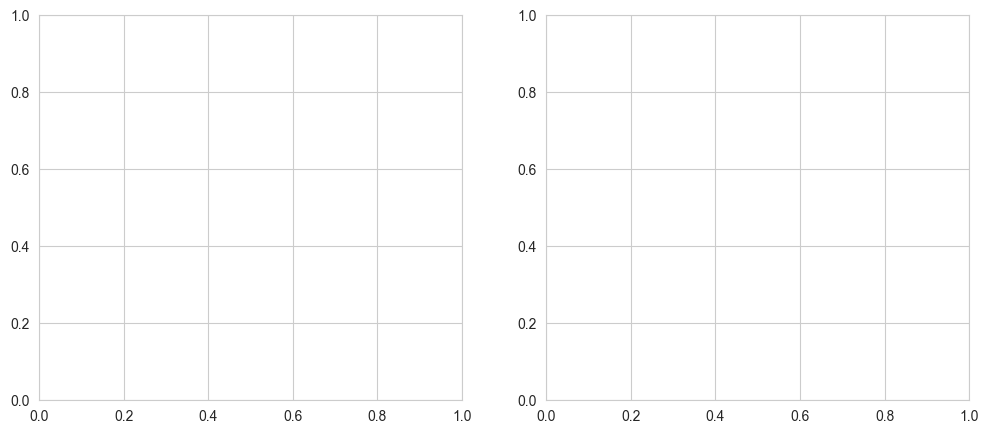

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# 1. 提取估计的后验均值和真实值
posterior_means = np.mean(posterior_samples_affine, axis=1)  # [test_size, 48]
theta_true_values = theta_true  # [test_size, 48]

# 2. 选择前两个参数 (p1, p2) 进行绘图
params = [0, 1]  # 选择 theta_1 和 theta_2
titles = [r"$p_1$", r"$p_2$"]

# 3. 绘制 2 张子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes):
    p_true = theta_true_values[:, params[i]]
    p_est = posterior_means[:, params[i]]

    # 计算 R^2 和 Pearson 相关系数
    r2 = r2_score(p_true, p_est)
    r, _ = pearsonr(p_true, p_est)

    # 绘制散点图
    ax.scatter(p_true, p_est, color="brown", alpha=0.5, s=10)
    
    # 绘制 y=x 参考线
    ax.plot([-2.5, 2.5], [-2.5, 2.5], linestyle="--", color="black")

    # 计算并显示 R^2 和 r 值
    ax.text(-2, 2, rf"$R^2 = {r2:.3f}$" + "\n" + rf"$r = {r:.3f}$",
            fontsize=14, bbox=dict(facecolor="white", edgecolor="black", alpha=0.7))

    # 轴标签
    ax.set_xlabel("Ground truth", fontsize=14)
    ax.set_ylabel("Estimated", fontsize=14)
    ax.set_title(titles[i], fontsize=16)
    ax.grid(alpha=0.3)

# 调整布局
plt.tight_layout()
plt.show()


In [116]:
posterior_samples_spline= spline_flow_workflow.approximator.sample(
    conditions={"inference_conditions": x_test},  # 改为 inference_conditions
    num_samples=num_samples
)["theta"]

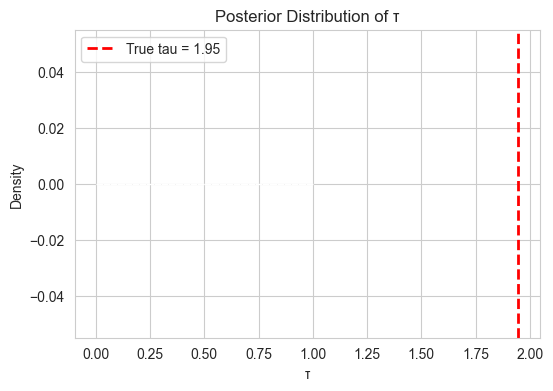

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# 提取 tau 的采样（对于第一个测试样本）
tau_samples = posterior_samples_spline[0, :, -1]  # shape: (300,)
tau_true = theta_true[0, -1]               # 标量

plt.figure(figsize=(6, 4))
sns.histplot(tau_samples, bins=30, kde=True, color="skyblue")
plt.axvline(tau_true, color='red', linestyle='--', linewidth=2,
            label=f"True tau = {tau_true:.2f}")
plt.title("Posterior Distribution of τ")
plt.xlabel("τ")
plt.ylabel("Density")
plt.legend()
plt.show()



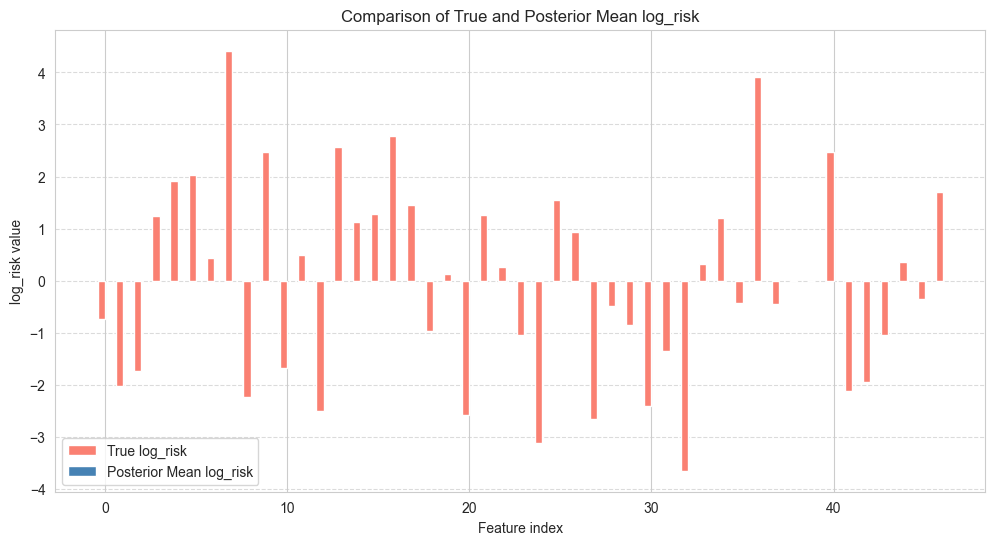

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# 提取 log_risk 部分
log_risk_samples = posterior_samples_spline[0, :, :47]  # shape: (300, 47)
log_risk_mean = np.mean(log_risk_samples, axis=0)  # shape: (47,)
log_risk_true = theta_true[0, :47]                 # shape: (47,)

x = np.arange(47)

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, log_risk_true, width=0.4, label="True log_risk", color="salmon")
plt.bar(x + 0.2, log_risk_mean, width=0.4, label="Posterior Mean log_risk", color="steelblue")
plt.xlabel("Feature index")
plt.ylabel("log_risk value")
plt.title("Comparison of True and Posterior Mean log_risk")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 生成测试数据（调用 simulator 得到原始数据，经 adapter 转换后键名为 inference_variables 和 inference_conditions）
test_size = 100
test_batch_100 = simulator.sample((test_size,))



In [133]:
# 提取 theta_true 和 x_test
theta_true_100 = test_batch_100["theta"]  # [test_size, 48]
x_test_100 = test_batch_100["x"]  # [test_size, 4700]


In [134]:
posterior_samples_affine= affine_flow_workflow.approximator.sample(
    conditions={"inference_conditions": x_test_100},  # 改为 inference_conditions
    num_samples=300
)["theta"]

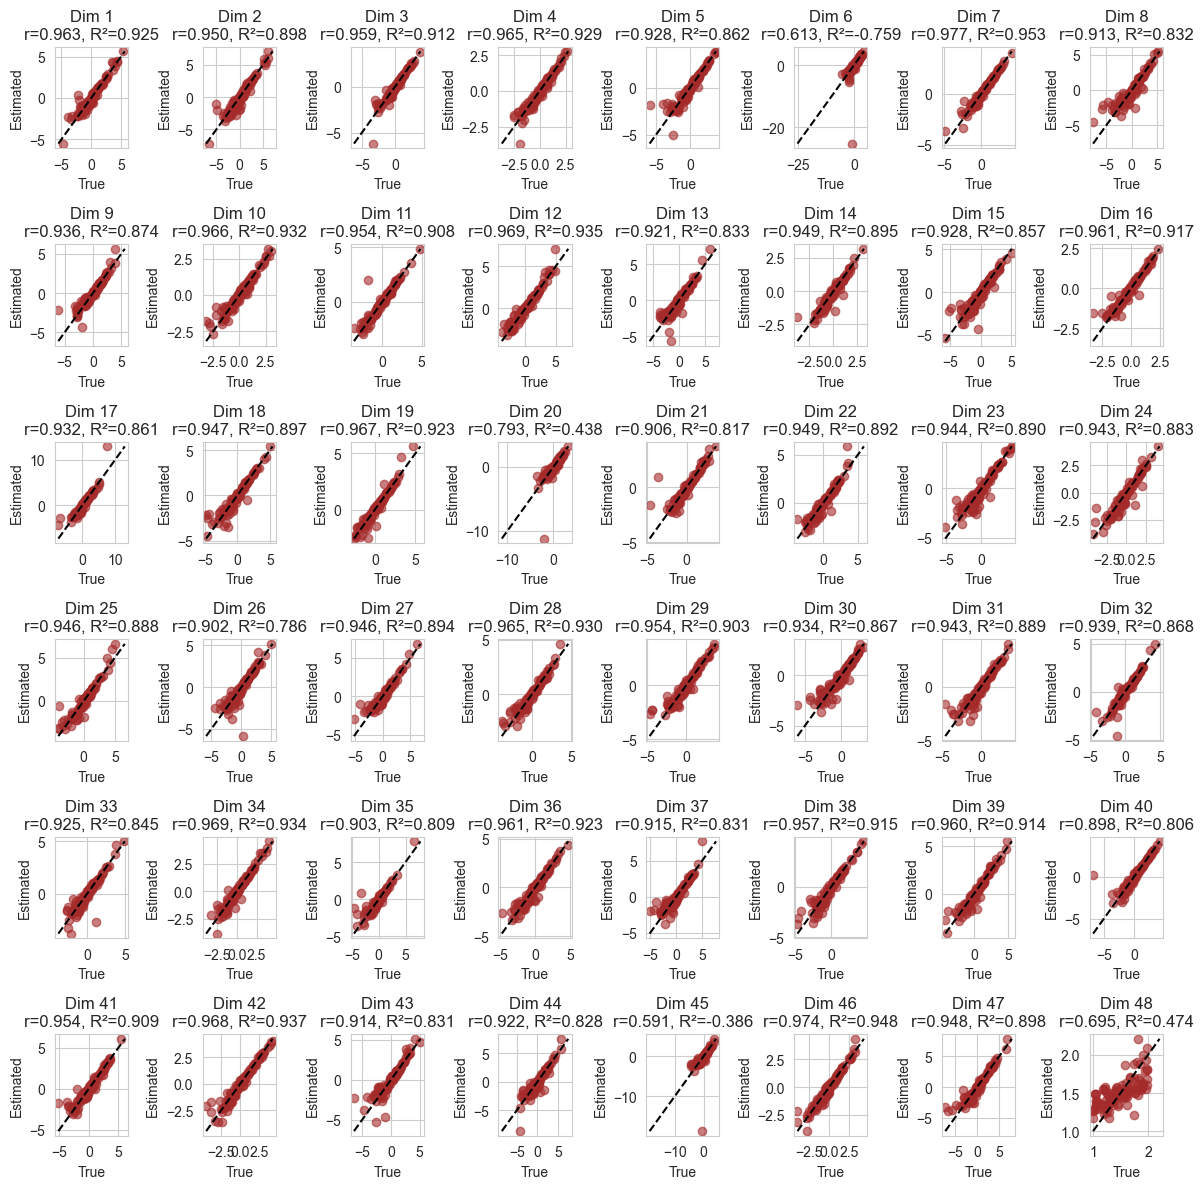

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# posterior_samples_affine.shape = (test_size, 300, 48)
# theta_true_100.shape = (test_size, 48)
test_size = theta_true_100.shape[0]
n_dim = theta_true_100.shape[1]

# 计算后验均值 => shape (test_size, 48)
posterior_means = posterior_samples_affine.mean(axis=1)

# 只画前16个维度（若要全48个可以自行调整行列排布）
n_plot_dims =48

fig, axes = plt.subplots(6, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(n_plot_dims):
    ax = axes[i]
    # x轴是真值, y轴是后验均值
    ax.scatter(theta_true_100[:, i], posterior_means[:, i], alpha=0.6, color="brown")
    
    # 画对角线
    min_val = min(theta_true_100[:, i].min(), posterior_means[:, i].min())
    max_val = max(theta_true_100[:, i].max(), posterior_means[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], "k--")

    # 相关系数 & R^2
    r = np.corrcoef(theta_true_100[:, i], posterior_means[:, i])[0, 1]
    r2 = r2_score(theta_true_100[:, i], posterior_means[:, i])
    
    ax.set_title(f"Dim {i+1}\nr={r:.3f}, R²={r2:.3f}")
    ax.set_xlabel("True")
    ax.set_ylabel("Estimated")

plt.tight_layout()
plt.show()


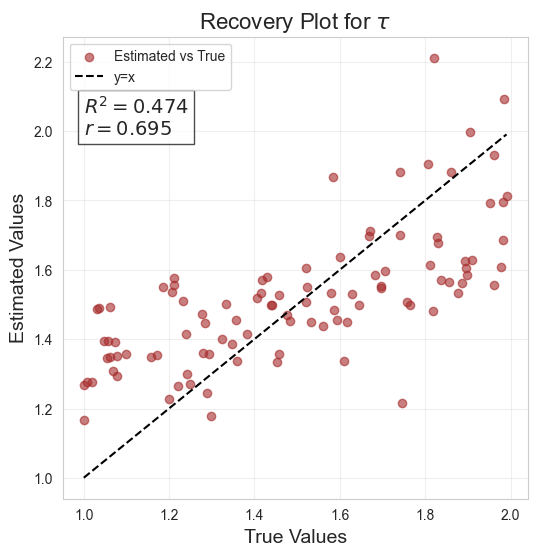

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 选择第 48 维参数（索引从 0 开始，所以索引是 47）
dim_index = 47  # θ_48

# 提取真实值与后验均值
true_values = theta_true_100[:, dim_index]  # shape: (test_size,)
estimated_values = posterior_means[:, dim_index]  # shape: (test_size,)

# 计算 Pearson 相关系数和 R²
r = np.corrcoef(true_values, estimated_values)[0, 1]
r2 = r2_score(true_values, estimated_values)

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(true_values, estimated_values, alpha=0.6, color="brown", label="Estimated vs True")
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], "k--", label="y=x")  # 对角线

# 相关系数和 R²
plt.text(true_values.min(), true_values.max(), rf"$R^2 = {r2:.3f}$" + "\n" + rf"$r = {r:.3f}$",
         fontsize=14, bbox=dict(facecolor="white", edgecolor="black", alpha=0.7))

# 轴标签和标题
plt.xlabel("True Values", fontsize=14)
plt.ylabel("Estimated Values", fontsize=14)
plt.title(r"Recovery Plot for $\tau$", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)

# 显示图像
plt.show()


In [129]:
import bayesflow.diagnostics as diag

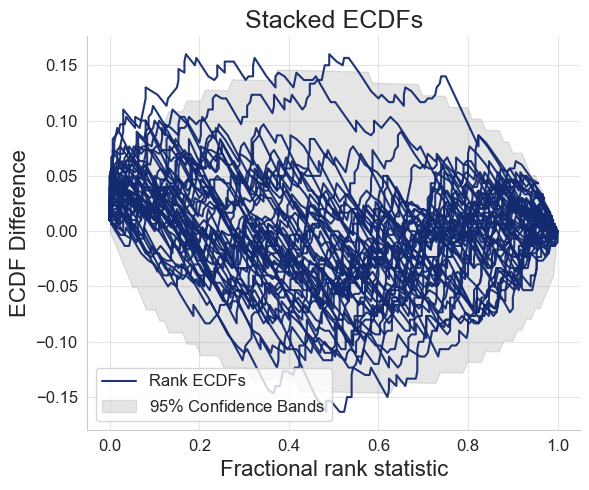

In [139]:
f = diag.calibration_ecdf(
    targets=posterior_samples_affine,   # 后验采样, shape (N=100, S=300, D=48)
    references=theta_true_100,          # 真参数,   shape (N=100, D=48)
    stacked=True,
    difference=True,
    legend_fontsize=12,
    figsize=(6, 5)                      # 注意参数名是 figsize
)

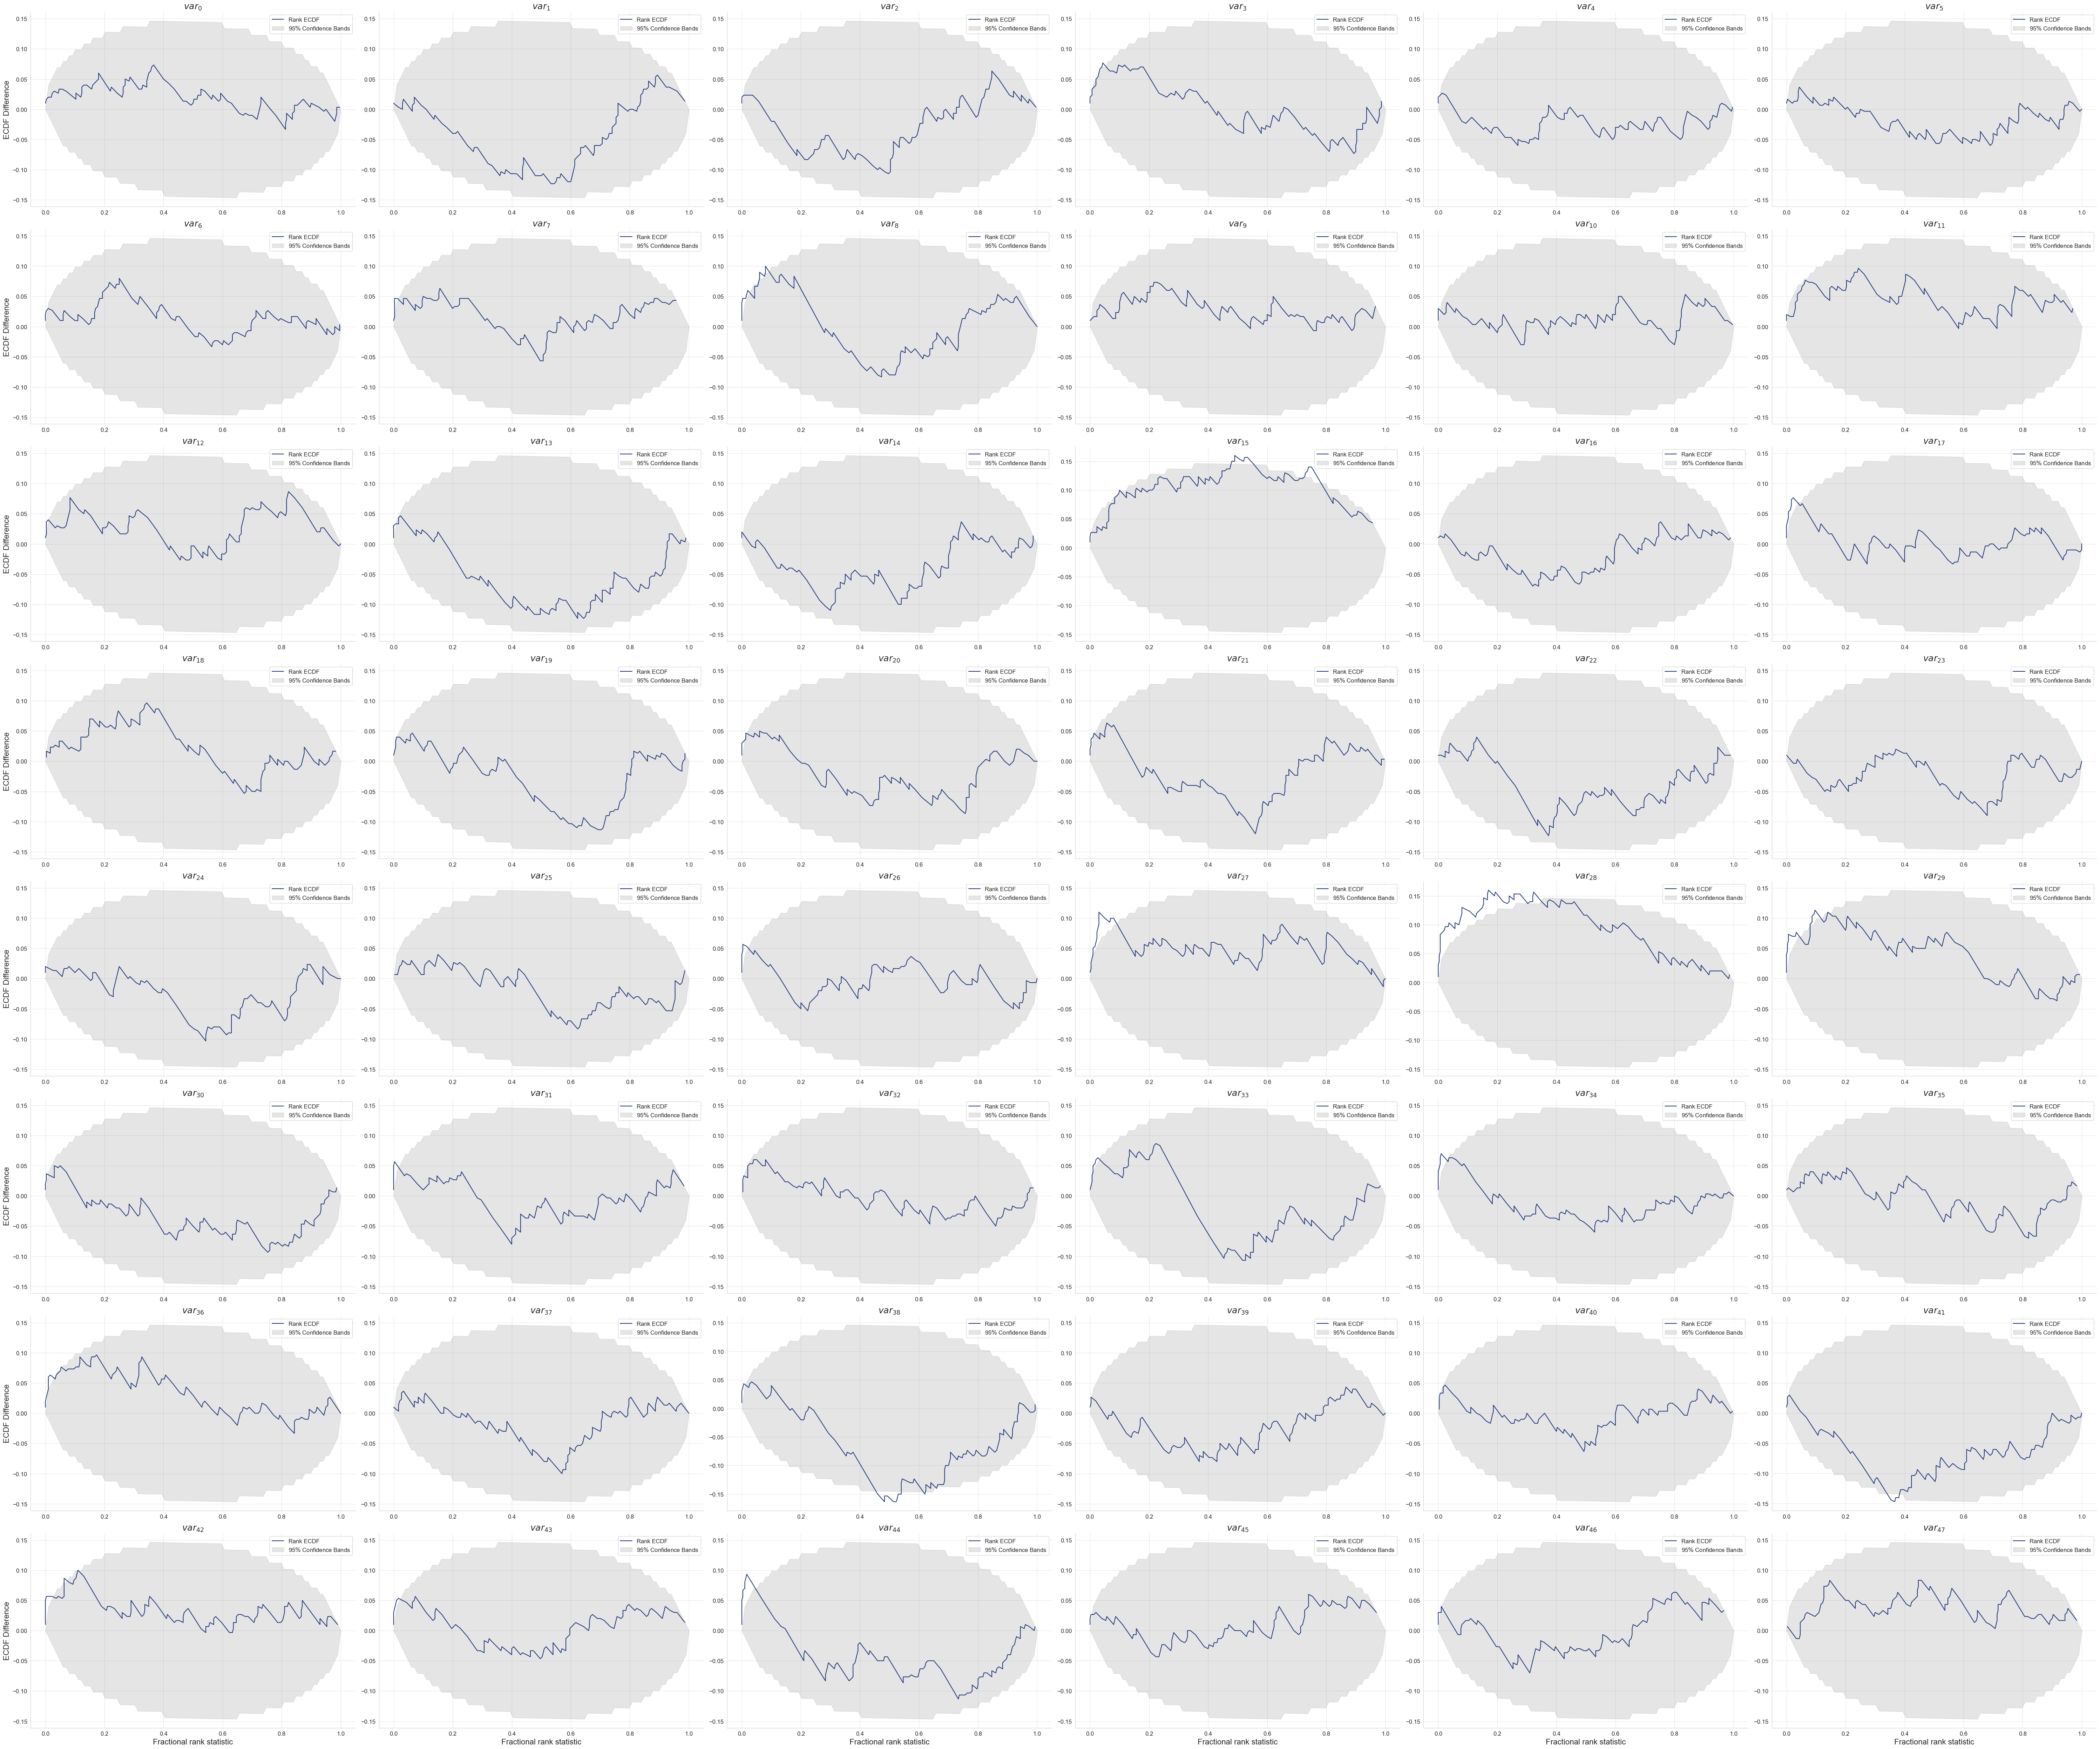

In [141]:
f = diag.calibration_ecdf(
    targets=posterior_samples_affine,   # 后验采样, shape (N=100, S=300, D=48)
    references=theta_true_100,          # 真参数,   shape (N=100, D=48)
    stacked=False,
    difference=True,
    legend_fontsize=12,
    figsize=(60, 50)                      # 注意参数名是 figsize
)

In [146]:
posterior_samples_affine.shape #(100, 300, 48)

(100, 300, 48)

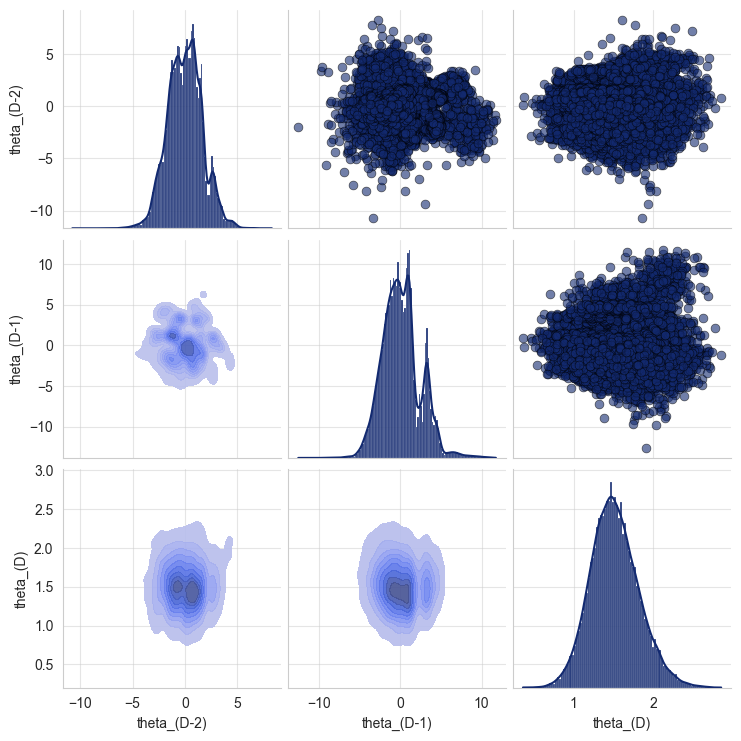

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import bayesflow.diagnostics as diag

# 假设 posterior_samples_affine 的形状为 (test_size, n_samples, 48)
# 将其 reshape 为 (test_size * n_samples, 48)
flattened_samples = posterior_samples_affine.reshape(-1, posterior_samples_affine.shape[-1])

# 提取最后 3 个参数（维度）
subset = {
    "log_risk 46": flattened_samples[:, -3],
    "log_risk 47": flattened_samples[:, -2],
    "tau":   flattened_samples[:, -1]
}

# 调用 pairs_samples 绘制 Pair Plot
grid = diag.plots.pairs_samples(subset)

plt.show()


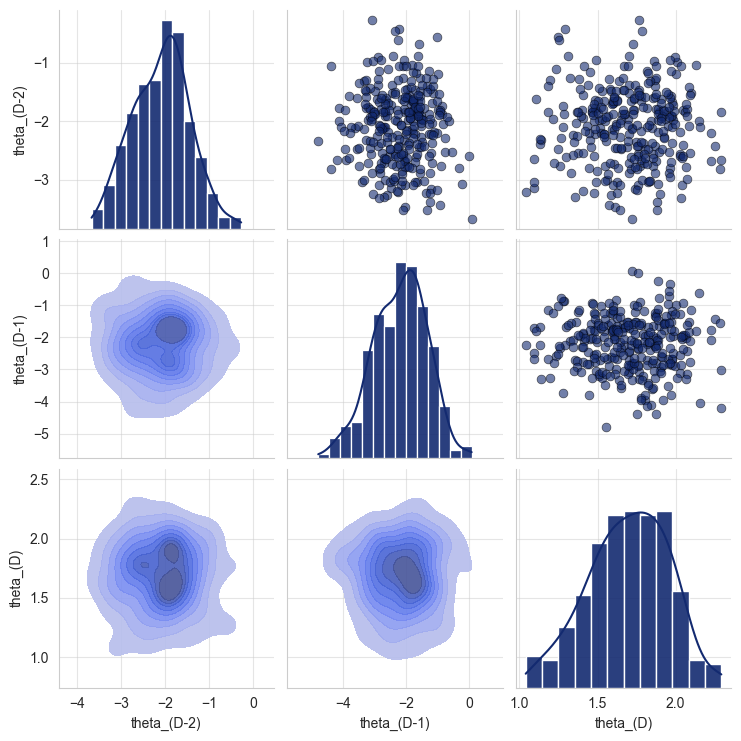

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import bayesflow.diagnostics as diag

# 假设 posterior_samples_affine 的形状为 (100, 300, 48)
# 如果只取第一个测试实例的后验采样，形状为 (300, 48)
posterior_first = posterior_samples_affine[0]  

# 提取最后 3 个参数（维度）
subset = {
    "theta_(D-2)": posterior_first[:, -3],
    "theta_(D-1)": posterior_first[:, -2],
    "theta_(D)":   posterior_first[:, -1]
}

# 调用 pairs_samples 绘制 Pair Plot
grid = diag.plots.pairs_samples(subset)

plt.show()
